In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from function import *

In [3]:
df = make_data(dt=0.01, total_time = 50)

In [4]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [5]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [6]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
sc_train_x = scaler.fit_transform(train_x)
sc_test_x = scaler.transform(test_x)

sc_train_y = scaler.fit_transform(train_y.reshape(-1, 1))
sc_test_y = scaler.transform(test_y.reshape(-1, 1))

In [10]:
model = hysterisis_curve(sc_train_x, sc_train_y, sc_test_x, sc_test_y)

In [11]:
model.dnn_fit(epochs=100, batch_size=1)

Epoch 1/100


4000/4000 [==============================] - 4s 827us/step - loss: 0.1880 - mse: 0.1880
Epoch 2/100
4000/4000 [==============================] - 3s 820us/step - loss: 0.1687 - mse: 0.1687
Epoch 3/100
4000/4000 [==============================] - 3s 819us/step - loss: 0.1652 - mse: 0.1652
Epoch 4/100
4000/4000 [==============================] - 3s 838us/step - loss: 0.1631 - mse: 0.1631
Epoch 5/100
4000/4000 [==============================] - 3s 851us/step - loss: 0.1627 - mse: 0.1627
Epoch 6/100
4000/4000 [==============================] - 3s 847us/step - loss: 0.1612 - mse: 0.1612
Epoch 7/100
4000/4000 [==============================] - 3s 831us/step - loss: 0.1610 - mse: 0.1610
Epoch 8/100
4000/4000 [==============================] - 3s 867us/step - loss: 0.1606 - mse: 0.1606
Epoch 9/100
4000/4000 [==============================] - 4s 908us/step - loss: 0.1610 - mse: 0.1610
Epoch 10/100
4000/4000 [==============================] - 3s 856us/step - loss: 0.1602 - mse: 0.1602
Epoch 11/10

In [19]:
pred = model.dnn_predict()

32/32 [==============================] - 0s 920us/step


In [26]:
real_pred = scaler.inverse_transform(pred)

In [37]:
test_x[:,0]

array([-9.79717439e-15,  6.27905195e-02,  1.25333234e-01, ...,
       -1.25333234e-01, -6.27905195e-02,  1.96438672e-15])

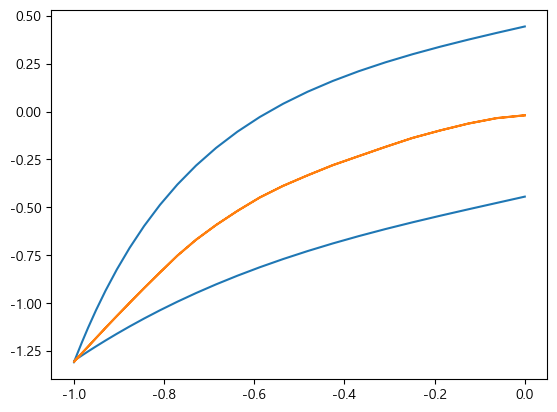

In [79]:
plt.plot(test_x[950:,0], test_y[950:], label='real')
plt.plot(test_x[950:,0], real_pred.reshape(1,-1)[0][950:], label='pred')

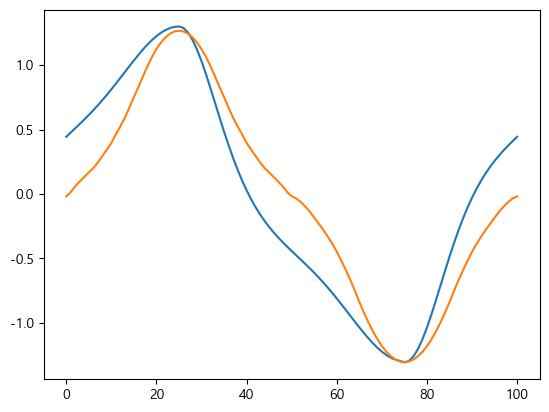

In [77]:
plt.plot(test_y[900:])
plt.plot(real_pred.reshape(1,-1)[0][900:])
plt.show()

In [80]:
lstm_history = model.lstm_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.2061 - mse: 0.2061
Epoch 2/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1698 - mse: 0.1698
Epoch 3/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1658 - mse: 0.1658
Epoch 4/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1661 - mse: 0.1661
Epoch 5/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1643 - mse: 0.1643
Epoch 6/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1638 - mse: 0.1638
Epoch 7/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1632 - mse: 0.1632
Epoch 8/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1639 - mse: 0.1639
Epoch 9/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1615 - mse: 0.1615
Epoch 10/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1617 - mse: 0.1617
Epoch 11/100
4000/4

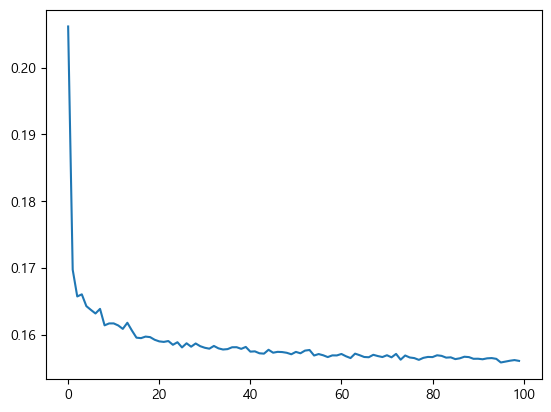

In [91]:
plt.plot(lstm_history.history.history['loss'])

In [93]:
lstm_pred = model.lstm_predict()

32/32 [==============================] - 1s 1ms/step


In [96]:
real_lstm_pred = scaler.inverse_transform(lstm_pred)

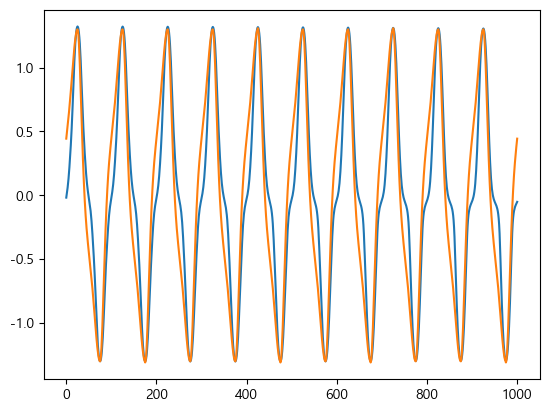

In [102]:
plt.plot(real_lstm_pred.reshape(1,-1)[0])
plt.plot(test_y)

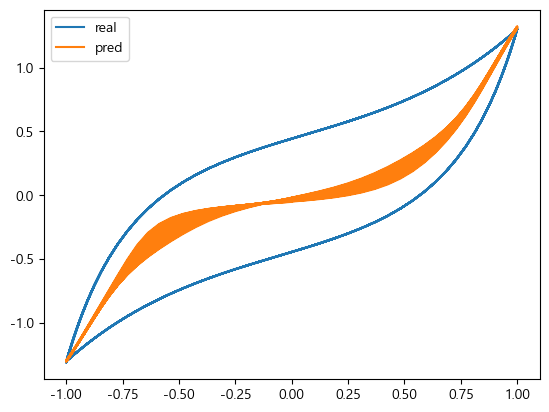

In [115]:
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_lstm_pred, label='pred')
plt.legend()
plt.show()